In [19]:
# Library ----------------------------------------------------------------
library(dplyr)
library(tidyr)
library(ggplot2)
library(sondr)
library(clessnize)
library(ggtext)
library(tidytext)

# 1. Load Data and Clustering Results ---------------------------
kmeans_result <- readRDS("../../../_PrivateFolder_datagotchi_federal_2025/data/clustering/qc2022/03_pilot1_kmeans.rds")
df_pilot1_2022 <- readRDS("../../../_PrivateFolder_datagotchi_federal_2025/data/clustering/qc2022/03_pilot1_2022.rds")
cluster_means <- read.csv("../../../_PrivateFolder_datagotchi_federal_2025/data/clustering/qc2022/03_pilot1_clusters_desc.csv")
df_pilot1_2022_with_issues <- readRDS("../../../_SharedFolder_datagotchi_federal_2024/data/clustering/qc_2022/datagotchiQuebec2022_pilote1Clean.rds")


In [20]:
# Enlever toutes les variables sauf id et enjeux

Df_pilot1_issues <- df_pilot1_2022_with_issues |> 
  select(id, starts_with("issue_"))

# Bind df avec enjeux au pilote utilisé auparavant

Df_validation <- merge(df_pilot1_2022, Df_pilot1_issues, by = "id")

In [31]:
# Préparer mes variables

# Liste des variables d'enjeux
variables_issues <- c(
  "issue_systemicRacismExistQc",
  "issue_proImmigration",
  "issue_reduceDeficit",
  "issue_proPrivateHealth", 
  "issue_protectFrench", 
  "issue_proQcIndependance",
  "issue_proTeachersReligiousSymbols",
  "issue_proStrictEnviroRules",
  "issue_QcTooPolCorrect",
  "issue_abortionMoreAccessibleQc",
  "issue_begin3eLienImportant",
  "issue_respectGHGReductionImportant"
)

# Chemin d’enregistrement des graphiques
output_path <- "../../../_PrivateFolder_datagotchi_federal_2025/graph/clustering/qc_2022"

colnames(Df_validation)
Df_validation$cluster <- as.factor(kmeans_result$cluster)

In [32]:
# Créer une fonction pour calculer l'importance relative de chaque variable -----------------------------

calculate_importance <- function(data, variables) {
  importance_scores <- sapply(variables, function(var) {
    overall_mean <- mean(data[[var]], na.rm = TRUE)
    cluster_means <- tapply(data[[var]], data$cluster, mean, na.rm = TRUE)
    abs_diff <- abs(cluster_means - overall_mean) / sd(data[[var]], na.rm = TRUE)
    return(mean(abs_diff, na.rm = TRUE))
  })
  importance_scores <- importance_scores / sum(importance_scores)  # Normaliser pour obtenir des proportions
  return(importance_scores)
}

# Calculer l'importance relative pour les variables d'enjeux
importance_scores <- calculate_importance(Df_validation, variables_issues)
print(importance_scores)

       issue_systemicRacismExistQc               issue_proImmigration 
                        0.11519084                         0.05474014 
               issue_reduceDeficit             issue_proPrivateHealth 
                        0.10082650                         0.08917097 
               issue_protectFrench            issue_proQcIndependance 
                        0.08655477                         0.07066472 
 issue_proTeachersReligiousSymbols         issue_proStrictEnviroRules 
                        0.07444432                         0.08521317 
             issue_QcTooPolCorrect     issue_abortionMoreAccessibleQc 
                        0.07640469                         0.09612015 
        issue_begin3eLienImportant issue_respectGHGReductionImportant 
                        0.07533486                         0.07533486 
       issue_systemicRacismExistQc               issue_proImmigration 
                        0.11519084                         0.05474014 
      

In [34]:
# Fonction pour identifier les caractéristiques clés de chaque cluster ---------------------
identify_characteristics <- function(cluster_data, overall_data, var_name, p_value_threshold, effect_size_threshold, proportion_diff_threshold) {
  if (all(overall_data[[var_name]] %in% c(0, 1))) {
    prop_cluster <- mean(cluster_data[[var_name]], na.rm = TRUE)
    prop_overall <- mean(overall_data[[var_name]], na.rm = TRUE)
    p_value <- prop.test(x = c(sum(cluster_data[[var_name]]), sum(overall_data[[var_name]])), 
                         n = c(nrow(cluster_data), nrow(overall_data)))$p.value
    prop_diff <- abs(prop_cluster - prop_overall)
    if (p_value < p_value_threshold && prop_diff > proportion_diff_threshold) {
      return(ifelse(prop_cluster > prop_overall, "green", "red"))
    }
  } else {
    t_test <- t.test(cluster_data[[var_name]], overall_data[[var_name]])
    effect_size <- abs(t_test$estimate[1] - t_test$estimate[2]) / sd(overall_data[[var_name]], na.rm = TRUE)
    if (t_test$p.value < p_value_threshold && effect_size > effect_size_threshold) {
      return(ifelse(t_test$estimate[1] > t_test$estimate[2], "green", "red"))
    }
  }
  return("black")
}


In [35]:
# Fonction pour décrire les personas ------------------------------------------------------
describe_personas <- function(data, kmeans_result, variables, persona_names = NULL, p_value_threshold = 0.01, effect_size_threshold = 0.5, proportion_diff_threshold = 0.1) {
  data$cluster <- as.factor(kmeans_result$cluster)
  
  variable_names <- variables
  persona_summary <- data %>%
    group_by(cluster) %>%
    summarise(across(all_of(variable_names), list(mean = ~mean(.x, na.rm = TRUE), sd = ~sd(.x, na.rm = TRUE))))
  
  print(persona_summary)
}

# Appliquer la description des personas
describe_personas(Df_validation, kmeans_result, variables_issues)

# Préparation des données pour la visualisation des personas ----------------------------------------
all_data_viz <- data.frame()

for (cluster_value in levels(Df_validation$cluster)) {
  cluster_data <- Df_validation %>% filter(cluster == cluster_value)
  means <- sapply(variables_issues, function(var) mean(cluster_data[[var]], na.rm = TRUE))
  overall_means <- sapply(variables_issues, function(var) mean(Df_validation[[var]], na.rm = TRUE))
  
  # Identification des caractéristiques marquantes
  characteristic_vars <- sapply(variables_issues, function(var) {
    if (all(Df_validation[[var]] %in% c(0, 1))) {
      prop_cluster <- mean(cluster_data[[var]], na.rm = TRUE)
      prop_overall <- mean(Df_validation[[var]], na.rm = TRUE)
      p_value <- prop.test(x = c(sum(cluster_data[[var]]), sum(Df_validation[[var]])), 
                           n = c(nrow(cluster_data), nrow(Df_validation)))$p.value
      prop_diff <- abs(prop_cluster - prop_overall)
      return(ifelse(p_value < 0.05 && prop_diff > 0.3, ifelse(prop_cluster > prop_overall, "green", "red"), "black"))
    } else {
      t_test <- t.test(cluster_data[[var]], Df_validation[[var]])
      effect_size <- abs(t_test$estimate[1] - t_test$estimate[2]) / sd(Df_validation[[var]], na.rm = TRUE)
      return(ifelse(t_test$p.value < 0.05 && effect_size > 0.25, ifelse(t_test$estimate[1] > t_test$estimate[2], "green", "red"), "black"))
    }
  })

  # Calculs des proportions de femmes, d'immigrants, âge et revenu moyen
  perc_femmes <- mean(cluster_data$female, na.rm = TRUE) * 100
  perc_immigrants <- mean(cluster_data$immigrant, na.rm = TRUE) * 100
  age_mean <- mean(cluster_data$age, na.rm = TRUE)
  revenu_moyen <- mean(cluster_data$ses_income, na.rm = TRUE)
  
  # Préparation des données pour le graphique
  data_viz <- data.frame(Variable = variables_issues, Mean = means, Overall = overall_means, Cluster = cluster_value)
  data_viz$Color <- characteristic_vars
  data_viz$Persona <- paste("Persona", cluster_value)
  all_data_viz <- rbind(all_data_viz, data_viz)
  
  # Génération du prompt de suggestion de noms
  cat(paste0("\nPour le persona ", cluster_value, " :\n",
             "Variables supérieures :\n",
             if (any(characteristic_vars == "green")) {
               paste(variables_issues[characteristic_vars == "green"], collapse = "\n")
             } else {
               "Aucune variable supérieure ne se distingue fortement."
             },
             "\nVariables inférieures :\n",
             if (any(characteristic_vars == "red")) {
               paste(variables_issues[characteristic_vars == "red"], collapse = "\n")
             } else {
               "Aucune variable inférieure ne se distingue fortement."
             },
             "\n\nCe cluster est composé de ", round(perc_femmes, 1), "% de femmes, ", 
             round(perc_immigrants, 1), "% d'immigrants, un âge moyen de ", round(age_mean, 1), 
             " ans et un revenu moyen de ", round(revenu_moyen, 1), " k$.\n"
  ))
}



# A tibble: 6 × 25
  cluster issue_systemicRacismEx…¹ issue_systemicRacism…² issue_proImmigration…³
  <fct>                      <dbl>                  <dbl>                  <dbl>
1 1                          0.675                  0.301                  0.508
2 2                          0.522                  0.356                  0.533
3 3                          0.664                  0.326                  0.522
4 4                          0.712                  0.306                  0.627
5 5                          0.721                  0.321                  0.567
6 6                          0.582                  0.319                  0.523
# ℹ abbreviated names: ¹​issue_systemicRacismExistQc_mean,
#   ²​issue_systemicRacismExistQc_sd, ³​issue_proImmigration_mean
# ℹ 21 more variables: issue_proImmigration_sd <dbl>,
#   issue_reduceDeficit_mean <dbl>, issue_reduceDeficit_sd <dbl>,
#   issue_proPrivateHealth_mean <dbl>, issue_proPrivateHealth_sd <dbl>,
#   issue_protec


Pour le persona 1 :
Variables supérieures :
Aucune variable supérieure ne se distingue fortement.
Variables inférieures :
Aucune variable inférieure ne se distingue fortement.

Ce cluster est composé de 99.8% de femmes, 4.6% d'immigrants, un âge moyen de 0.6 ans et un revenu moyen de 0.4 k$.

Pour le persona 2 :
Variables supérieures :
issue_reduceDeficit
Variables inférieures :
issue_systemicRacismExistQc

Ce cluster est composé de 0.5% de femmes, 6.4% d'immigrants, un âge moyen de 0.7 ans et un revenu moyen de 0.4 k$.

Pour le persona 3 :
Variables supérieures :
Aucune variable supérieure ne se distingue fortement.
Variables inférieures :
issue_proPrivateHealth

Ce cluster est composé de 60.2% de femmes, 12.2% d'immigrants, un âge moyen de 0.6 ans et un revenu moyen de 0.2 k$.

Pour le persona 4 :
Variables supérieures :
issue_proImmigration
issue_proTeachersReligiousSymbols
issue_begin3eLienImportant
issue_respectGHGReductionImportant
Variables inférieures :
issue_protectFrench
iss


Pour le persona 5 :
Variables supérieures :
issue_systemicRacismExistQc
issue_abortionMoreAccessibleQc
Variables inférieures :
issue_reduceDeficit
issue_proPrivateHealth
issue_QcTooPolCorrect

Ce cluster est composé de 36.7% de femmes, 14.4% d'immigrants, un âge moyen de 0.5 ans et un revenu moyen de 0.4 k$.

Pour le persona 6 :
Variables supérieures :
Aucune variable supérieure ne se distingue fortement.
Variables inférieures :
issue_proStrictEnviroRules

Ce cluster est composé de 50.3% de femmes, 6.1% d'immigrants, un âge moyen de 0.6 ans et un revenu moyen de 0.5 k$.


Pour le persona 5 :
Variables supérieures :
issue_systemicRacismExistQc
issue_abortionMoreAccessibleQc
Variables inférieures :
issue_reduceDeficit
issue_proPrivateHealth
issue_QcTooPolCorrect

Ce cluster est composé de 36.7% de femmes, 14.4% d'immigrants, un âge moyen de 0.5 ans et un revenu moyen de 0.4 k$.

Pour le persona 6 :
Variables supérieures :
Aucune variable supérieure ne se distingue fortement.
Variables i

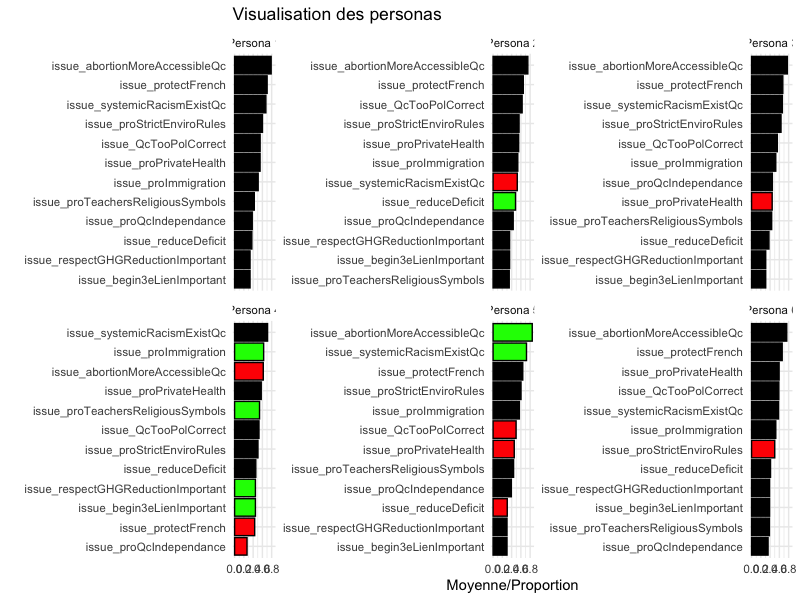

In [36]:
# Tri des données pour le graphique
all_data_viz <- all_data_viz %>%
  group_by(Persona) %>%
  arrange(desc(Mean)) %>%
  ungroup()

# Sauvegarder le graphique
ggplot(all_data_viz, aes(x = reorder_within(Variable, Mean, Persona), y = Mean, fill = Color)) +
  geom_bar(stat = "identity", color = "black", show.legend = FALSE) +
  scale_fill_identity() +
  labs(title = "Visualisation des personas", x = "", y = "Moyenne/Proportion") +
  theme_minimal() +
  coord_flip() +
  facet_wrap(~ Persona, scales = "free_y") +
  scale_x_reordered()

In [37]:
# Créer une fonction pour enjeu par cluster (pour ne pas avoir à créer 12 graphiques un par un)

generate_graph <- function(data, issue_variable, output_path) {
  
  # Convertir la variable en symbole
  issue_sym <- ensym(issue_variable)
  
  # Regroupement et génération du graphique
  data |> 
    group_by(cluster_name, !!issue_sym) |> 
    summarise(nombre_de_repondants = n(), .groups = "drop") |> 
    group_by(cluster_name) |> 
    mutate(
      nombre_total_de_repondants = sum(nombre_de_repondants),
      proportion = nombre_de_repondants / nombre_total_de_repondants
    ) |> 
    ggplot(aes(x = !!issue_sym, y = proportion, fill = factor(cluster_name))) +
    geom_col() +
    facet_wrap(~ cluster_name) +
    labs(
      x = as_label(issue_sym),  # Affiche la variable dynamiquement dans le label
      y = "Proportion",
      fill = "Cluster",
      title = paste("Distribution of", as_label(issue_sym), "by Cluster")
    ) +
    theme_clean_light() -> graph
  
  # Sauvegarder le graphique
  ggsave(
    filename = paste0(output_path, "/validationCluster_", as_label(issue_sym), ".pdf"),
    plot = graph,
    width = 16,
    height = 12
  )
}

# Loop pour générer les graphiques

# Utiliser lapply pour créer les graphiques
lapply(variables_issues, function(issue) {
  generate_graph(Df_validation, !!sym(issue), output_path)
})

[[1]]
[1] "../../../_PrivateFolder_datagotchi_federal_2025/graph/clustering/qc_2022/validationCluster_issue_systemicRacismExistQc.pdf"

[[2]]
[1] "../../../_PrivateFolder_datagotchi_federal_2025/graph/clustering/qc_2022/validationCluster_issue_proImmigration.pdf"

[[3]]
[1] "../../../_PrivateFolder_datagotchi_federal_2025/graph/clustering/qc_2022/validationCluster_issue_reduceDeficit.pdf"

[[4]]
[1] "../../../_PrivateFolder_datagotchi_federal_2025/graph/clustering/qc_2022/validationCluster_issue_proPrivateHealth.pdf"

[[5]]
[1] "../../../_PrivateFolder_datagotchi_federal_2025/graph/clustering/qc_2022/validationCluster_issue_protectFrench.pdf"

[[6]]
[1] "../../../_PrivateFolder_datagotchi_federal_2025/graph/clustering/qc_2022/validationCluster_issue_proQcIndependance.pdf"

[[7]]
[1] "../../../_PrivateFolder_datagotchi_federal_2025/graph/clustering/qc_2022/validationCluster_issue_proTeachersReligiousSymbols.pdf"

[[8]]
[1] "../../../_PrivateFolder_datagotchi_federal_2025/graph/clusterin

In [8]:
 
# Créer une fonction par enjeu pour la proportion totale pour meilleure comparaison ----

generate_graph_all <- function(data, issue_variable, output_path) {
  
  # Convertir la variable en symbole
  issue_sym <- ensym(issue_variable)
  
  # Regroupement et génération du graphique
  data |> 
    group_by(!!issue_sym) |> 
    summarise(nombre_de_repondants = n(), .groups = "drop") |> 
    mutate(
      nombre_total_de_repondants = sum(nombre_de_repondants),
      proportion = nombre_de_repondants / nombre_total_de_repondants
    ) |> 
    ggplot(aes(x = !!issue_sym, y = proportion, fill = factor(!!issue_sym))) +
    geom_col(show.legend = FALSE) +
    labs(
      x = as_label(issue_sym),  # Affiche la variable dynamiquement dans le label
      y = "Proportion",
      title = paste("Distribution of", as_label(issue_sym), "among all respondents")
    ) +
    theme_clean_light() -> graph
  
  # Sauvegarder le graphique
  ggsave(
    filename = paste0(output_path, "/distribution_all_", as_label(issue_sym), ".pdf"),
    plot = graph,
    width = 16,
    height = 12
  )
}

# Loop pour générer les graphiques
lapply(variables_issues, function(issue) {
  generate_graph_all(Df_validation, !!sym(issue), output_path)
})

[[1]]
[1] "../../../_PrivateFolder_datagotchi_federal_2025/graph/clustering/qc_2022/distribution_all_issue_systemicRacismExistQc.pdf"

[[2]]
[1] "../../../_PrivateFolder_datagotchi_federal_2025/graph/clustering/qc_2022/distribution_all_issue_proImmigration.pdf"

[[3]]
[1] "../../../_PrivateFolder_datagotchi_federal_2025/graph/clustering/qc_2022/distribution_all_issue_reduceDeficit.pdf"

[[4]]
[1] "../../../_PrivateFolder_datagotchi_federal_2025/graph/clustering/qc_2022/distribution_all_issue_proPrivateHealth.pdf"

[[5]]
[1] "../../../_PrivateFolder_datagotchi_federal_2025/graph/clustering/qc_2022/distribution_all_issue_protectFrench.pdf"

[[6]]
[1] "../../../_PrivateFolder_datagotchi_federal_2025/graph/clustering/qc_2022/distribution_all_issue_proQcIndependance.pdf"

[[7]]
[1] "../../../_PrivateFolder_datagotchi_federal_2025/graph/clustering/qc_2022/distribution_all_issue_proTeachersReligiousSymbols.pdf"

[[8]]
[1] "../../../_PrivateFolder_datagotchi_federal_2025/graph/clustering/qc_20